In [5]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# Later, for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [6]:
def update_calendar(cutoff):
    calendar_update = calendar.iloc[:cutoff, :]
    calendar_dates = calendar_update[['date', 'd']]
    calendar_dates = calendar_dates.set_index('d')
    return calendar_dates

def drop_christmas(series):
    df = calendar[['date', 'd']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['month'] = df.index.month
    df['day'] = df.index.day
    month_mask = df['month'] == 12
    day_mask = df['day'] == 25
    df = df[month_mask & day_mask]
    df = df.drop(columns = ['month', 'day'])
    df['date'] = df.index
    df = df.set_index('d')
    lst = df.index.tolist()
    return series.drop(index = lst)

def make_date_time(Series):
    df = pd.DataFrame(Series)
    df1 = df.join(calendar_updates)
    df1['date'] = pd.to_datetime(df1['date'])
    df1 = df1.set_index('date')
    return df1

#To make a graph with a linear trendline
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)
    
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)    
    
# To make a detrended graph
def detrended_graph(Series):
    python_series = Series
    python_linear_trend = fit_linear_trend(python_series)
    python_series_detrended = python_series - python_linear_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(python_series_detrended.index, python_series_detrended)
    ax.set_title("Walmart Total Food Sales Detrended")
    plt.tight_layout()
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    i = series.index.interval
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(i).iloc[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series, interval='month'):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)
    
#fig, ax = plt.subplots(figsize=(14, 5))
#plot_seasonal_trend(ax, 'hobbies', df1)
#plt.tight_layout()

def deseasonalize(Series):
    series = Series.iloc[:, 0]
    seasonal_trend = fit_seasonal_trend(Series)
    easonal_detrended = series - seasonal_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(Series.index, _seasonal_detrended)
    ax.set_title(f'Walmart {list(Series)[0]} Sales, Deseasonalized')
    
def resample_series(series, interval):
    df = series.resample(interval).sum()
    df = df.iloc[1:, :]
    df = df.iloc[:-1, :]
    return df

def plot_seasonal_decomposition(axs, series):
    sd = sm.tsa.seasonal_decompose(series)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

In [7]:
sales_train = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

calendar_updates = update_calendar(1913)

sales_train_cat = sales_train.groupby(['cat_id']).sum()
sales_train_cat_food = sales_train_cat.iloc[0, :].T
sales_train_cat_hobbies = sales_train_cat.iloc[1, :].T
sales_train_cat_household = sales_train_cat.iloc[2, :].T

sales_train_cat.loc['TOTAL']= sales_train_cat.sum()
sales_train_cat_all = sales_train_cat.iloc[3, :].T

sales_train_dept = sales_train.groupby(['dept_id']).sum()
sales_train_dept_food1 = sales_train_dept.iloc[0, :].T
sales_train_dept_food2 = sales_train_dept.iloc[1, :].T
sales_train_dept_food3 = sales_train_dept.iloc[2, :].T
sales_train_dept_hobbies1 = sales_train_dept.iloc[3, :].T
sales_train_dept_hobbies2 = sales_train_dept.iloc[4, :].T
sales_train_dept_household1 = sales_train_dept.iloc[5, :].T
sales_train_dept_household2 = sales_train_dept.iloc[6, :].T

sales_train_state = sales_train.groupby(['state_id']).sum()
sales_train_ca = sales_train_state.iloc[0, :].T
sales_train_tx = sales_train_state.iloc[1, :].T
sales_train_wi = sales_train_state.iloc[2, :].T

sales_train_store = sales_train.groupby(['store_id']).sum()
sales_train_ca1 = sales_train_store.iloc[0, :].T
sales_train_ca2 = sales_train_store.iloc[1, :].T
sales_train_ca3 = sales_train_store.iloc[2, :].T
sales_train_ca4 = sales_train_store.iloc[3, :].T
sales_train_tx1 = sales_train_store.iloc[4, :].T
sales_train_tx2 = sales_train_store.iloc[5, :].T
sales_train_tx3 = sales_train_store.iloc[6, :].T
sales_train_wi1 = sales_train_store.iloc[7, :].T
sales_train_wi2 = sales_train_store.iloc[8, :].T
sales_train_wi3 = sales_train_store.iloc[9, :].T

sales_train_cat_food = drop_christmas(sales_train_cat_food)
sales_train_cat_hobbies = drop_christmas(sales_train_cat_hobbies)
sales_train_cat_household = drop_christmas(sales_train_cat_household)

sales_train_cat_all = drop_christmas(sales_train_cat_all)

sales_train_dept_food1 = drop_christmas(sales_train_dept_food1)
sales_train_dept_food2 = drop_christmas(sales_train_dept_food2)
sales_train_dept_food3 = drop_christmas(sales_train_dept_food3)
sales_train_dept_hobbies1 = drop_christmas(sales_train_dept_hobbies1)
sales_train_dept_hobbies2 = drop_christmas(sales_train_dept_hobbies2)
sales_train_dept_household1 = drop_christmas(sales_train_dept_household1)
sales_train_dept_household2 = drop_christmas(sales_train_dept_household2)

sales_train_ca = drop_christmas(sales_train_ca)
sales_train_tx = drop_christmas(sales_train_tx)
sales_train_wi = drop_christmas(sales_train_wi)

sales_train_ca1 = drop_christmas(sales_train_ca1)
sales_train_ca2 = drop_christmas(sales_train_ca2)
sales_train_ca3 = drop_christmas(sales_train_ca3)
sales_train_ca4 = drop_christmas(sales_train_ca4)
sales_train_tx1 = drop_christmas(sales_train_tx1)
sales_train_tx2 = drop_christmas(sales_train_tx2)
sales_train_tx3 = drop_christmas(sales_train_tx3)
sales_train_wi1 = drop_christmas(sales_train_wi1)
sales_train_wi2 = drop_christmas(sales_train_wi2)
sales_train_wi3 = drop_christmas(sales_train_wi3)

big_food = make_date_time(sales_train_cat_food)
big_hobby = make_date_time(sales_train_cat_hobbies)
big_household = make_date_time(sales_train_cat_household)

big_all = make_date_time(sales_train_cat_all)

med_food1 = make_date_time(sales_train_dept_food1)
med_food2 = make_date_time(sales_train_dept_food2)
med_food3 = make_date_time(sales_train_dept_food3)
med_hobby1 = make_date_time(sales_train_dept_hobbies1)
med_hobby2 = make_date_time(sales_train_dept_hobbies2)
med_household1 = make_date_time(sales_train_dept_household1)
med_household2 = make_date_time(sales_train_dept_household2)

state_ca = make_date_time(sales_train_ca)
state_tx = make_date_time(sales_train_tx)
state_wi = make_date_time(sales_train_wi)

store_ca1 = make_date_time(sales_train_ca1)
store_ca2 = make_date_time(sales_train_ca2)
store_ca3 = make_date_time(sales_train_ca3)
store_ca4 = make_date_time(sales_train_ca4)
store_tx1 = make_date_time(sales_train_tx1)
store_tx2 = make_date_time(sales_train_tx2)
store_tx3 = make_date_time(sales_train_tx3)
store_wi1 = make_date_time(sales_train_wi1)
store_wi2 = make_date_time(sales_train_wi2)
store_wi3 = make_date_time(sales_train_wi3)

series_lst = [big_all, big_food, big_hobby, big_household,
              med_food1, med_food2, med_food3, med_hobby1, med_hobby2, med_household1, med_household2,
              state_ca, state_tx, state_wi,
              store_ca1, store_ca2, store_ca3, store_ca4, store_tx1, store_tx2, store_tx3, store_wi1, store_wi2, store_wi3
             ]

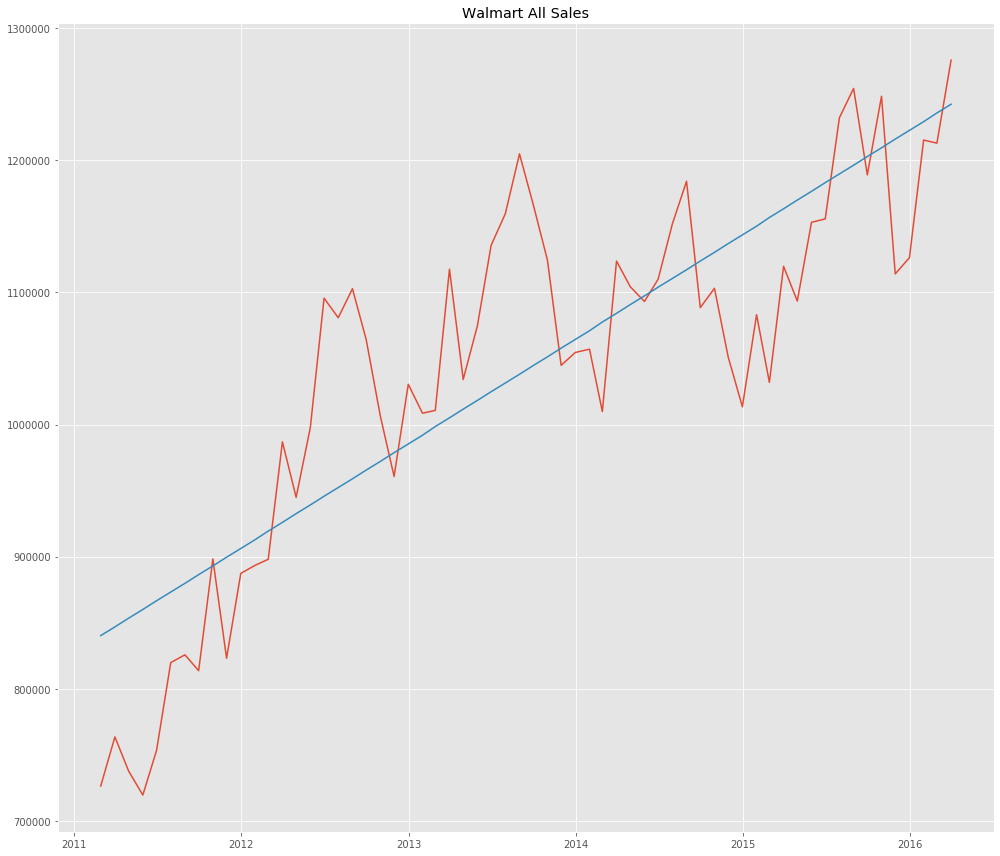

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart All Sales', resample_series(big_all, 'M'))
plt.tight_layout()

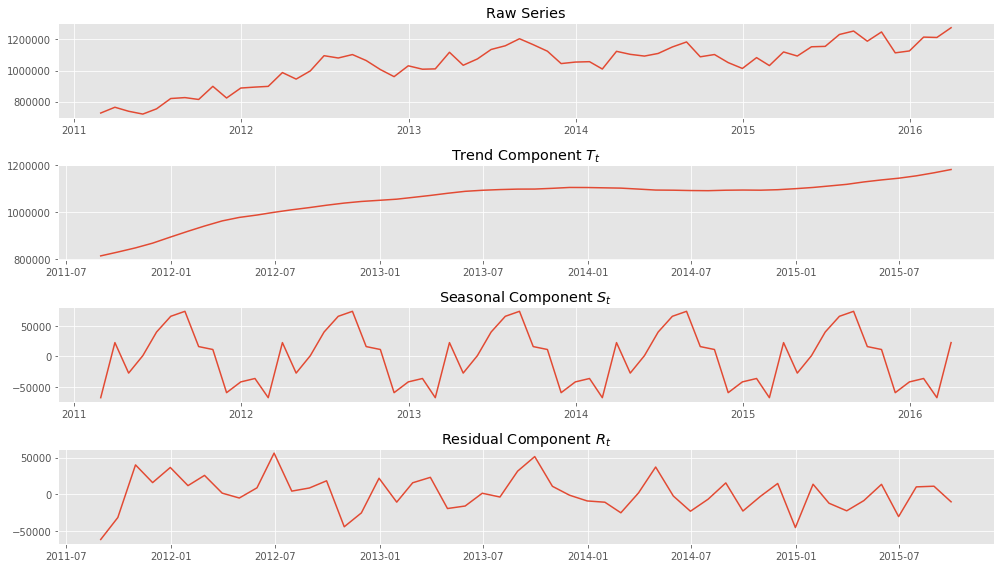

In [9]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_all, 'M'))
plt.tight_layout()

In [10]:
series = resample_series(big_all, 'M')
d = series[:-2]

X = make_design_matrix(np.arange(len(d)) + 1)
linear_trend_ols = sm.OLS(d.values, X).fit()

In [11]:
linear_trend_ols

In [12]:
slope_intercept = linear_trend_ols.params
slope = slope_intercept[0]
intercept = slope_intercept[1]

In [13]:
linear_trend_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     127.7
Date:                Thu, 14 May 2020   Prob (F-statistic):           2.74e-16
Time:                        14:12:49   Log-Likelihood:                -759.99
No. Observations:                  60   AIC:                             1524.
Df Residuals:                      58   BIC:                             1528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6572.6856    581.523     11.303      0.000    5408.641    7736.731
const       8.341e+05   2.04e+04     40.893      0.000    7.93e+05    8.75e+05
==============================================================================
Omnibus:                        1.901   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.519
Skew:                           0.215   Prob(JB):                        0.468
Kurtosis:                       2.350   Cond. No.                         71.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
len(d)

60

In [15]:
#Feb 2016
feb_2016_trend = slope*(len(d) + 1) + intercept
feb_2016_trend

1234997.0259887006

In [16]:
#March 2016
mar_2016_trend = slope*(len(d) + 2) + intercept
mar_2016_trend

1241569.7115402427

In [17]:
sd = sm.tsa.seasonal_decompose(series)
seasonal_pattern_all = sd.seasonal[11:23]
seasonal_pattern_all

,TOTAL
date,
2012-01-31,-36384.078472
2012-02-29,-68087.974306
2012-03-31,22940.806944
2012-04-30,-27437.443056
2012-05-31,1365.859028
2012-06-30,40421.088194
2012-07-31,66409.671528
2012-08-31,74654.444444
2012-09-30,16363.486111


In [18]:
feb_2016_seasonal = seasonal_pattern_all.loc[seasonal_pattern_all.index.month == 2].iloc[0, 0]
feb_2016_seasonal

-68087.97430555554

In [19]:
mar_2016_seasonal = seasonal_pattern_all.loc[seasonal_pattern_all.index.month == 3].iloc[0, 0]
mar_2016_seasonal

22940.80694444449

In [20]:
feb_2016_forecast = feb_2016_trend + feb_2016_seasonal
feb_2016_forecast

1166909.051683145

In [21]:
mar_2016_forecast = mar_2016_trend + mar_2016_seasonal
mar_2016_forecast

1264510.5184846872

In [22]:
feb_2016_actual = series[-2:].loc[series[-2:].index.month == 2].iloc[0, 0]
feb_2016_actual

1212927

In [23]:
mar_2016_actual = series[-2:].loc[series[-2:].index.month == 3].iloc[0, 0]
mar_2016_actual

1275746

In [24]:
error_feb = feb_2016_forecast - feb_2016_actual
error_feb/feb_2016_actual

-0.03793958607307356

In [25]:
error_mar = mar_2016_forecast - mar_2016_actual
error_mar/mar_2016_actual

-0.008806989412714444

In [26]:
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


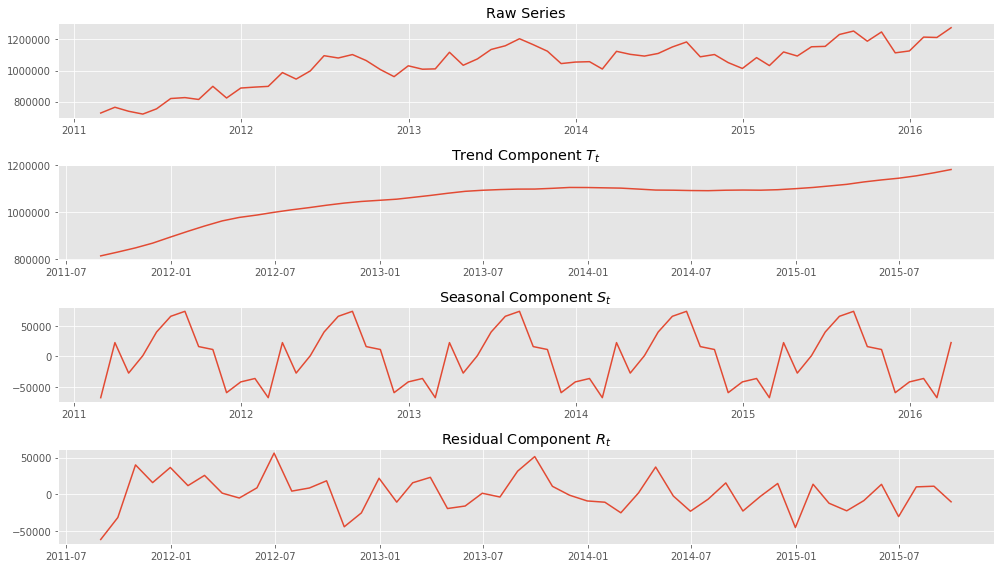

In [27]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_all, 'M'))
plt.tight_layout()

In [28]:
sales_all = sales_train_cat.T
sales_all = drop_christmas(sales_all)
sales_all = make_date_time(sales_all)
sales_all = resample_series(sales_all, 'M')
sales_all['foods_percent'] = sales_all['FOODS']/sales_all['TOTAL']
sales_all['hobbies_percent'] = sales_all['HOBBIES']/sales_all['TOTAL']
sales_all['household_percent'] = sales_all['HOUSEHOLD']/sales_all['TOTAL']
sales_all

,FOODS,HOBBIES,HOUSEHOLD,TOTAL,foods_percent,hobbies_percent,household_percent
date,,,,,,,
2011-02-28,520250,77362,128763,726375,0.716228,0.106504,0.177268
2011-03-31,534914,83691,144962,763567,0.700546,0.109605,0.189848
2011-04-30,509568,86199,141946,737713,0.690740,0.116846,0.192414
2011-05-31,491753,87413,140396,719562,0.683406,0.121481,0.195113
2011-06-30,525861,84520,142999,753380,0.698002,0.112188,0.189810
...,...,...,...,...,...,...,...
2015-11-30,719316,119644,275016,1113976,0.645719,0.107403,0.246878
2015-12-31,725029,124529,276664,1126222,0.643771,0.110572,0.245657
2016-01-31,807440,117553,290293,1215286,0.664403,0.096729,0.238868


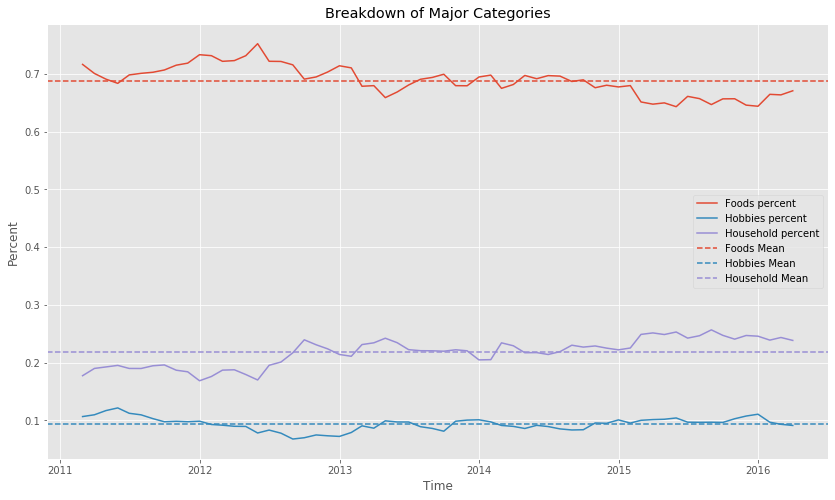

In [31]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_all['foods_percent'], label = 'Foods percent')
ax.plot(sales_all['hobbies_percent'], label = 'Hobbies percent')
ax.plot(sales_all['household_percent'], label = 'Household percent')
ax.axhline(y=sales_all.iloc[:, 4].mean(), xmin = 0, 
           linestyle = '--', color = 'C0', label = 'Foods Mean')
ax.axhline(y=sales_all.iloc[:, 5].mean(), xmin = 0, 
           linestyle = '--', color = 'C1', label = 'Hobbies Mean')
ax.axhline(y=sales_all.iloc[:, 6].mean(), xmin = 0, 
           linestyle = '--', color = 'C2', label = 'Household Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of Major Categories')
ax.legend()
plt.savefig('../images/breakdown_of_major_categories')
plt.show()

In [32]:
sales_all['hobbies_percent'].mean()

0.0937685411215939

In [33]:
sales_dept_all = sales_train_dept.copy()
sales_dept_all.loc['TOTAL']= sales_dept_all.sum()
sales_dept_all = sales_dept_all.T
sales_dept_all = drop_christmas(sales_dept_all)
sales_dept_all = make_date_time(sales_dept_all)
sales_dept_all = resample_series(sales_dept_all, 'M')
sales_dept_all['foods1_percent'] = sales_dept_all['FOODS_1']/sales_dept_all['TOTAL']
sales_dept_all['foods2_percent'] = sales_dept_all['FOODS_2']/sales_dept_all['TOTAL']
sales_dept_all['foods3_percent'] = sales_dept_all['FOODS_3']/sales_dept_all['TOTAL']
sales_dept_all['hobbies1_percent'] = sales_dept_all['HOBBIES_1']/sales_dept_all['TOTAL']
sales_dept_all['hobbies2_percent'] = sales_dept_all['HOBBIES_2']/sales_dept_all['TOTAL']
sales_dept_all['household1_percent'] = sales_dept_all['HOUSEHOLD_1']/sales_dept_all['TOTAL']
sales_dept_all['household2_percent'] = sales_dept_all['HOUSEHOLD_2']/sales_dept_all['TOTAL']
sales_dept_all

,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,TOTAL,foods1_percent,foods2_percent,foods3_percent,hobbies1_percent,hobbies2_percent,household1_percent,household2_percent
date,,,,,,,,,,,,,,,
2011-02-28,54155,97919,368176,73316,4046,90773,37990,726375,0.074555,0.134805,0.506868,0.100934,0.005570,0.124967,0.052301
2011-03-31,53527,101792,379595,78140,5551,105264,39698,763567,0.070101,0.133311,0.497134,0.102335,0.007270,0.137858,0.051990
2011-04-30,50678,95555,363335,80455,5744,103027,38919,737713,0.068696,0.129529,0.492515,0.109060,0.007786,0.139657,0.052756
2011-05-31,47358,95489,348906,81096,6317,99905,40491,719562,0.065815,0.132704,0.484887,0.112702,0.008779,0.138841,0.056272
2011-06-30,48418,101350,376093,79453,5067,104019,38980,753380,0.064268,0.134527,0.499208,0.105462,0.006726,0.138070,0.051740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-30,78354,155626,485336,106362,13282,224507,50509,1113976,0.070337,0.139703,0.435679,0.095480,0.011923,0.201537,0.045341
2015-12-31,99071,155008,470950,110357,14172,223716,52948,1126222,0.087968,0.137635,0.418168,0.097989,0.012584,0.198643,0.047014
2016-01-31,98250,175997,533193,107390,10163,236184,54109,1215286,0.080845,0.144819,0.438739,0.088366,0.008363,0.194344,0.044524


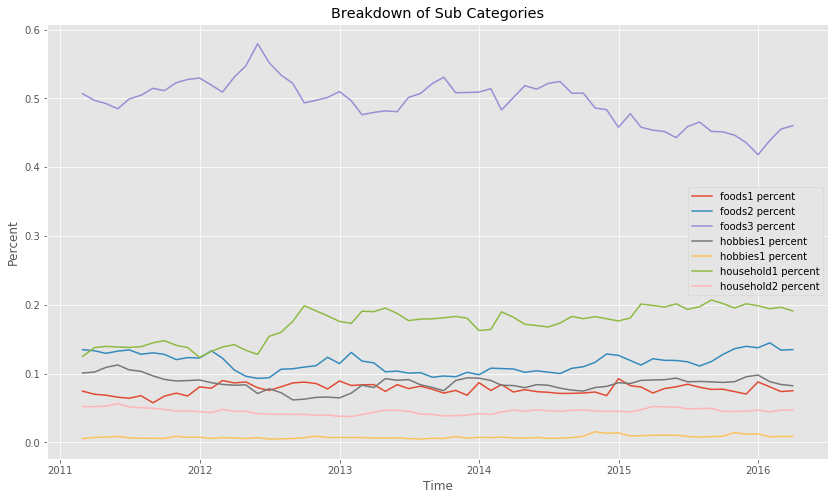

In [34]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_dept_all['foods1_percent'], label = 'foods1 percent')
ax.plot(sales_dept_all['foods2_percent'], label = 'foods2 percent')
ax.plot(sales_dept_all['foods3_percent'], label = 'foods3 percent')
ax.plot(sales_dept_all['hobbies1_percent'], label = 'hobbies1 percent')
ax.plot(sales_dept_all['hobbies2_percent'], label = 'hobbies1 percent')
ax.plot(sales_dept_all['household1_percent'], label = 'household1 percent')
ax.plot(sales_dept_all['household2_percent'], label = 'household2 percent')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of Sub Categories')
ax.legend()
plt.savefig('../images/breakdown_of_sub_categories_no_means')
plt.show()

In [35]:
sales_state_all = sales_train_state.copy()
sales_state_all.loc['TOTAL']= sales_state_all.sum()
sales_state_all = sales_state_all.T
sales_state_all = drop_christmas(sales_state_all)
sales_state_all = make_date_time(sales_state_all)
sales_state_all = resample_series(sales_state_all, 'M')
sales_state_all['ca_percent'] = sales_state_all['CA']/sales_state_all['TOTAL']
sales_state_all['tx_percent'] = sales_state_all['TX']/sales_state_all['TOTAL']
sales_state_all['wi_percent'] = sales_state_all['WI']/sales_state_all['TOTAL']

sales_state_all

,CA,TX,WI,TOTAL,ca_percent,tx_percent,wi_percent
date,,,,,,,
2011-02-28,318101,212015,196259,726375,0.437929,0.291881,0.270190
2011-03-31,339678,225162,198727,763567,0.444857,0.294882,0.260261
2011-04-30,331004,220681,186028,737713,0.448689,0.299142,0.252169
2011-05-31,321566,221620,176376,719562,0.446891,0.307993,0.245116
2011-06-30,332948,235653,184779,753380,0.441939,0.312794,0.245267
...,...,...,...,...,...,...,...
2015-11-30,482047,303714,328215,1113976,0.432727,0.272640,0.294634
2015-12-31,479551,305977,340694,1126222,0.425805,0.271684,0.302511
2016-01-31,525392,321790,368104,1215286,0.432320,0.264785,0.302895


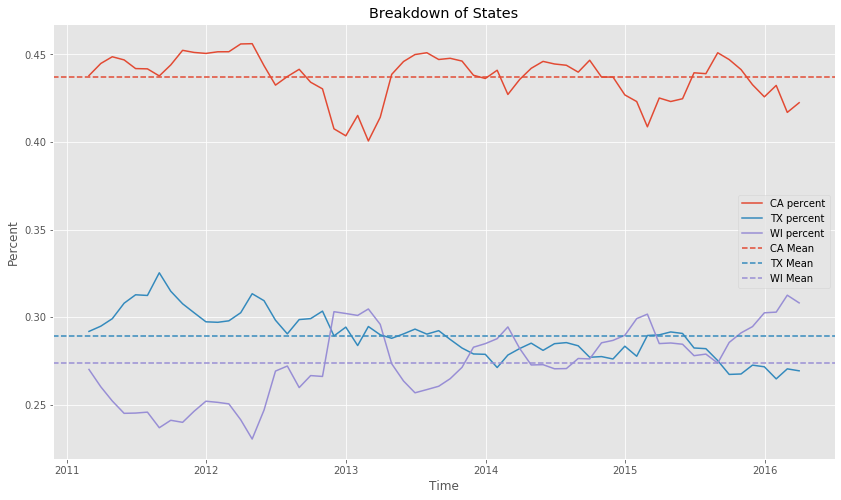

In [36]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_state_all['ca_percent'], label = 'CA percent')
ax.plot(sales_state_all['tx_percent'], label = 'TX percent')
ax.plot(sales_state_all['wi_percent'], label = 'WI percent')
ax.axhline(y=sales_state_all.iloc[:, 4].mean(), xmin = 0, 
           linestyle = '--', color = 'C0', label = 'CA Mean')
ax.axhline(y=sales_state_all.iloc[:, 5].mean(), xmin = 0, 
           linestyle = '--', color = 'C1', label = 'TX Mean')
ax.axhline(y=sales_state_all.iloc[:, 6].mean(), xmin = 0, 
           linestyle = '--', color = 'C2', label = 'WI Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of States')
ax.legend()
plt.savefig('../images/breakdown_of_states')
plt.show()

In [37]:
sales_store_all = sales_train_store.copy()
sales_store_all.loc['TOTAL']= sales_store_all.sum()
sales_store_all = sales_store_all.T
sales_store_all = drop_christmas(sales_store_all)
sales_store_all = make_date_time(sales_store_all)
sales_store_all = resample_series(sales_store_all, 'M')
sales_store_all['ca1_percent'] = sales_store_all['CA_1']/sales_store_all['TOTAL']
sales_store_all['ca2_percent'] = sales_store_all['CA_2']/sales_store_all['TOTAL']
sales_store_all['ca3_percent'] = sales_store_all['CA_3']/sales_store_all['TOTAL']
sales_store_all['ca4_percent'] = sales_store_all['CA_4']/sales_store_all['TOTAL']
sales_store_all['tx1_percent'] = sales_store_all['TX_1']/sales_store_all['TOTAL']
sales_store_all['tx2_percent'] = sales_store_all['TX_2']/sales_store_all['TOTAL']
sales_store_all['tx3_percent'] = sales_store_all['TX_3']/sales_store_all['TOTAL']
sales_store_all['wi1_percent'] = sales_store_all['WI_1']/sales_store_all['TOTAL']
sales_store_all['wi2_percent'] = sales_store_all['WI_2']/sales_store_all['TOTAL']
sales_store_all['wi3_percent'] = sales_store_all['WI_3']/sales_store_all['TOTAL']

sales_store_all

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,ca1_percent,ca2_percent,ca3_percent,ca4_percent,tx1_percent,tx2_percent,tx3_percent,wi1_percent,wi2_percent,wi3_percent
date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,89434,67686,119792,41189,62534,84900,64581,46592,51708,97959,...,0.123124,0.093183,0.164918,0.056705,0.086091,0.116882,0.088909,0.064143,0.071186,0.134860
2011-03-31,93468,73964,127344,44902,66890,89902,68370,49747,51113,97867,...,0.122410,0.096866,0.166775,0.058806,0.087602,0.117740,0.089540,0.065151,0.066940,0.128171
2011-04-30,91553,72803,122428,44220,66435,87683,66563,46898,47651,91479,...,0.124104,0.098687,0.165956,0.059942,0.090055,0.118858,0.090229,0.063572,0.064593,0.124004
2011-05-31,87988,68305,120711,44562,67920,86128,67572,45269,45487,85620,...,0.122280,0.094926,0.167756,0.061929,0.094391,0.119695,0.093907,0.062912,0.063215,0.118989
2011-06-30,90376,69380,129867,43325,69945,89914,75794,46776,50737,87266,...,0.119961,0.092092,0.172379,0.057507,0.092842,0.119347,0.100605,0.062088,0.067346,0.115833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-30,123590,117037,170986,70434,88531,109508,105675,102489,120937,104789,...,0.110945,0.105062,0.153492,0.063228,0.079473,0.098304,0.094863,0.092003,0.108563,0.094068
2015-12-31,123656,120396,167419,68080,89278,111871,104828,110441,126353,103900,...,0.109797,0.106903,0.148655,0.060450,0.079272,0.099333,0.093079,0.098063,0.112192,0.092255
2016-01-31,131598,128709,189217,75868,93112,116650,112028,113934,140948,113222,...,0.108286,0.105908,0.155698,0.062428,0.076617,0.095986,0.092182,0.093751,0.115979,0.093165


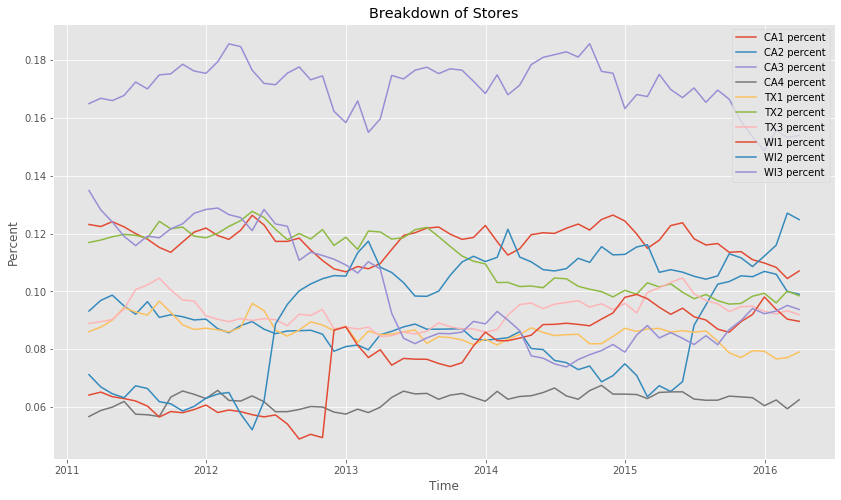

In [38]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_store_all['ca1_percent'], label = 'CA1 percent')
ax.plot(sales_store_all['ca2_percent'], label = 'CA2 percent')
ax.plot(sales_store_all['ca3_percent'], label = 'CA3 percent')
ax.plot(sales_store_all['ca4_percent'], label = 'CA4 percent')
ax.plot(sales_store_all['tx1_percent'], label = 'TX1 percent')
ax.plot(sales_store_all['tx2_percent'], label = 'TX2 percent')
ax.plot(sales_store_all['tx3_percent'], label = 'TX3 percent')
ax.plot(sales_store_all['wi1_percent'], label = 'WI1 percent')
ax.plot(sales_store_all['wi2_percent'], label = 'WI2 percent')
ax.plot(sales_store_all['wi3_percent'], label = 'WI3 percent')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of Stores')
ax.legend()
plt.savefig('../images/breakdown_of_stores_no_means')
plt.show()

In [39]:
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [40]:
mask1 = sales_train['store_id'] == 'CA_1'
mask2 = sales_train['dept_id'] == 'HOBBIES_1'
sales_train[mask1 & mask2]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,HOBBIES_1_420_CA_1_validation,HOBBIES_1_420,HOBBIES_1,HOBBIES,CA_1,CA,0,3,1,1,...,0,0,0,0,3,2,0,0,4,0
412,HOBBIES_1_421_CA_1_validation,HOBBIES_1_421,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,1,0,1,0,2,1
413,HOBBIES_1_422_CA_1_validation,HOBBIES_1_422,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,4,...,1,0,0,0,0,0,1,0,1,0
414,HOBBIES_1_423_CA_1_validation,HOBBIES_1_423,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,6,0,1,0,4,0,0,1,2


In [41]:
#Need to pick a work flow pipeline. Just focus on one category, one department, one state, and one store.
#I will have the total units sold for that store. Check notebook for pipeline.
#Need to figure out monthly breakdown.
#Need to adjust for holidays.
#Above, I was doing the breakdown by total units sold. Perhaps I need to do it as a function of the higher category.
    #ie hobby1 and hobby2 total will be the total in hobby as opposed to the total forecast?

In [42]:
sales_dept_food = sales_train_dept.iloc[:3, :].copy()
sales_dept_food.loc['TOTAL']= sales_dept_food.sum()
sales_dept_food = sales_dept_food.T
sales_dept_food = drop_christmas(sales_dept_food)
sales_dept_food = make_date_time(sales_dept_food)
sales_dept_food = resample_series(sales_dept_food, 'M')
sales_dept_food['foods1_percent'] = sales_dept_food['FOODS_1']/sales_dept_food['TOTAL']
sales_dept_food['foods2_percent'] = sales_dept_food['FOODS_2']/sales_dept_food['TOTAL']
sales_dept_food['foods3_percent'] = sales_dept_food['FOODS_3']/sales_dept_food['TOTAL']

sales_dept_food

,FOODS_1,FOODS_2,FOODS_3,TOTAL,foods1_percent,foods2_percent,foods3_percent
date,,,,,,,
2011-02-28,54155,97919,368176,520250,0.104094,0.188215,0.707691
2011-03-31,53527,101792,379595,534914,0.100067,0.190296,0.709637
2011-04-30,50678,95555,363335,509568,0.099453,0.187522,0.713026
2011-05-31,47358,95489,348906,491753,0.096304,0.194181,0.709515
2011-06-30,48418,101350,376093,525861,0.092074,0.192732,0.715195
...,...,...,...,...,...,...,...
2015-11-30,78354,155626,485336,719316,0.108928,0.216353,0.674719
2015-12-31,99071,155008,470950,725029,0.136644,0.213796,0.649560
2016-01-31,98250,175997,533193,807440,0.121681,0.217969,0.660350


In [43]:
sales_dept_food.iloc[40:, 4]

date
2014-06-30    0.104625
2014-07-31    0.102380
2014-08-31    0.103993
2014-09-30    0.104242
2014-10-31    0.108443
2014-11-30    0.100020
2014-12-31    0.136907
2015-01-31    0.121525
2015-02-28    0.123782
2015-03-31    0.111108
2015-04-30    0.120549
2015-05-31    0.125799
2015-06-30    0.128066
2015-07-31    0.122143
2015-08-31    0.119262
2015-09-30    0.117876
2015-10-31    0.112567
2015-11-30    0.108928
2015-12-31    0.136644
2016-01-31    0.121681
2016-02-29    0.111454
2016-03-31    0.112096
Freq: M, Name: foods1_percent, dtype: float64

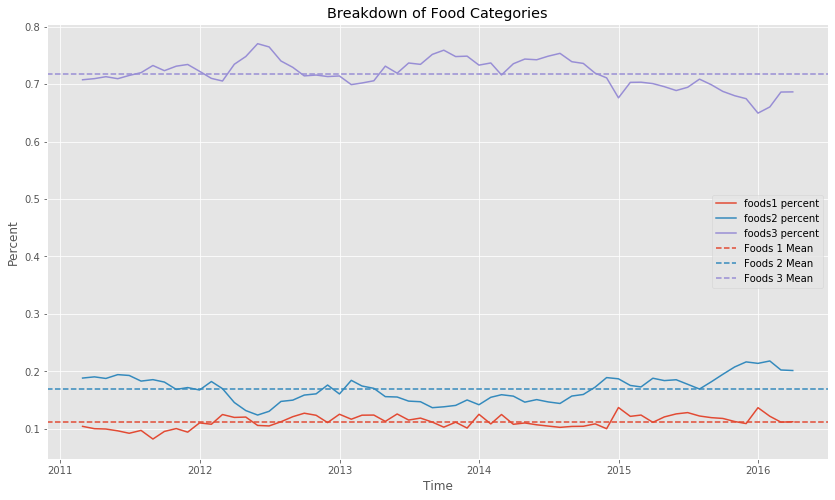

In [44]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_dept_food['foods1_percent'], label = 'foods1 percent')
ax.plot(sales_dept_food['foods2_percent'], label = 'foods2 percent')
ax.plot(sales_dept_food['foods3_percent'], label = 'foods3 percent')
ax.axhline(y=sales_dept_food.iloc[:, 4].mean(), xmin = 0, 
           linestyle = '--', color = 'C0', label = 'Foods 1 Mean')
ax.axhline(y=sales_dept_food.iloc[:, 5].mean(), xmin = 0, 
           linestyle = '--', color = 'C1', label = 'Foods 2 Mean')
ax.axhline(y=sales_dept_food.iloc[:, 6].mean(), xmin = 0, 
           linestyle = '--', color = 'C2', label = 'Foods 3 Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of Food Categories')
ax.legend()
plt.savefig('../images/breakdown_of_food_cat')
plt.show()

In [45]:
sales_dept_hobby = sales_train_dept.iloc[3:5, :].copy()
sales_dept_hobby.loc['TOTAL']= sales_dept_hobby.sum()
sales_dept_hobby = sales_dept_hobby.T
sales_dept_hobby = drop_christmas(sales_dept_hobby)
sales_dept_hobby = make_date_time(sales_dept_hobby)
sales_dept_hobby = resample_series(sales_dept_hobby, 'M')
sales_dept_hobby['hobbies1_percent'] = sales_dept_hobby['HOBBIES_1']/sales_dept_hobby['TOTAL']
sales_dept_hobby['hobbies2_percent'] = sales_dept_hobby['HOBBIES_2']/sales_dept_hobby['TOTAL']

sales_dept_hobby

,HOBBIES_1,HOBBIES_2,TOTAL,hobbies1_percent,hobbies2_percent
date,,,,,
2011-02-28,73316,4046,77362,0.947700,0.052300
2011-03-31,78140,5551,83691,0.933673,0.066327
2011-04-30,80455,5744,86199,0.933363,0.066637
2011-05-31,81096,6317,87413,0.927734,0.072266
2011-06-30,79453,5067,84520,0.940050,0.059950
...,...,...,...,...,...
2015-11-30,106362,13282,119644,0.888987,0.111013
2015-12-31,110357,14172,124529,0.886195,0.113805
2016-01-31,107390,10163,117553,0.913545,0.086455


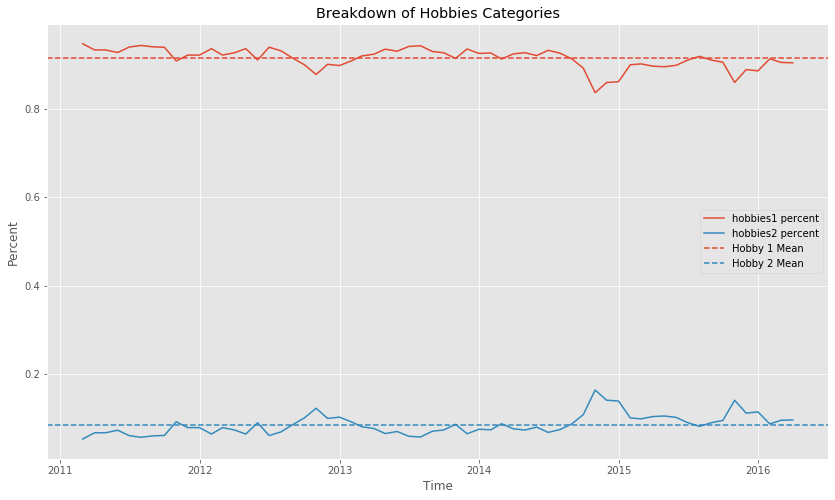

In [46]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_dept_hobby['hobbies1_percent'], label = 'hobbies1 percent')
ax.plot(sales_dept_hobby['hobbies2_percent'], label = 'hobbies2 percent')
ax.axhline(y=sales_dept_hobby.iloc[:, 3].mean(), xmin = 0, 
           linestyle = '--', color = 'C0', label = 'Hobby 1 Mean')
ax.axhline(y=sales_dept_hobby.iloc[:, 4].mean(), xmin = 0, 
           linestyle = '--', color = 'C1', label = 'Hobby 2 Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of Hobbies Categories')
ax.legend()
plt.savefig('../images/breakdown_of_hobby_cat')
plt.show()

In [47]:
sales_dept_household = sales_train_dept.iloc[5:7, :].copy()
sales_dept_household.loc['TOTAL']= sales_dept_household.sum()
sales_dept_household = sales_dept_household.T
sales_dept_household = drop_christmas(sales_dept_household)
sales_dept_household = make_date_time(sales_dept_household)
sales_dept_household = resample_series(sales_dept_household, 'M')
sales_dept_household['household1_percent'] = sales_dept_household['HOUSEHOLD_1']/sales_dept_household['TOTAL']
sales_dept_household['household2_percent'] = sales_dept_household['HOUSEHOLD_2']/sales_dept_household['TOTAL']

sales_dept_household

,HOUSEHOLD_1,HOUSEHOLD_2,TOTAL,household1_percent,household2_percent
date,,,,,
2011-02-28,90773,37990,128763,0.704962,0.295038
2011-03-31,105264,39698,144962,0.726149,0.273851
2011-04-30,103027,38919,141946,0.725818,0.274182
2011-05-31,99905,40491,140396,0.711594,0.288406
2011-06-30,104019,38980,142999,0.727411,0.272589
...,...,...,...,...,...
2015-11-30,224507,50509,275016,0.816342,0.183658
2015-12-31,223716,52948,276664,0.808620,0.191380
2016-01-31,236184,54109,290293,0.813606,0.186394


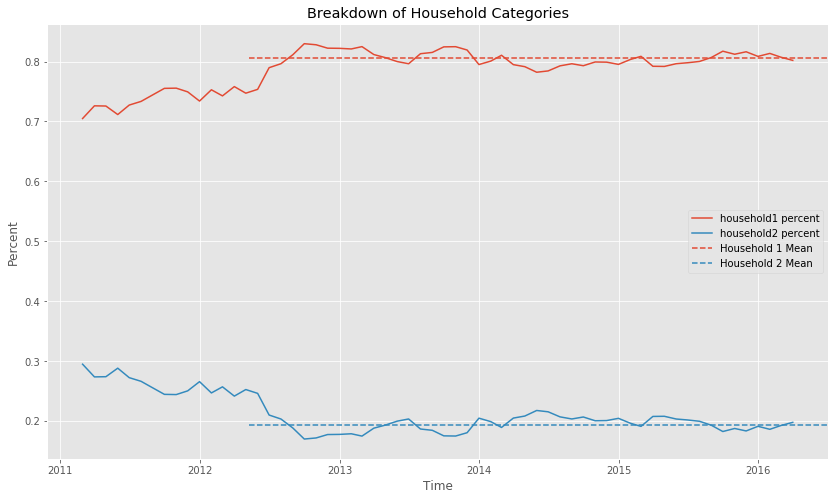

In [48]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_dept_household['household1_percent'], label = 'household1 percent')
ax.plot(sales_dept_household['household2_percent'], label = 'household2 percent')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of Household Categories')
ax.axhline(y=sales_dept_household.iloc[16:, 3].mean(), xmin = 16/62, 
           linestyle = '--', color = 'C0', label = 'Household 1 Mean')
ax.axhline(y=sales_dept_household.iloc[16:, 4].mean(), xmin = 16/62, 
           linestyle = '--', color = 'C1', label = 'Household 2 Mean')
ax.legend()
plt.savefig('../images/breakdown_of_household_categories')
plt.show()

In [49]:
sales_train_store.iloc[7:10, :]

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
store_id,,,,,,,,,,,,,,,,,,,,,
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127
WI_3,4038,4198,3317,3211,2132,4590,4486,5991,4850,3240,...,4613,4897,4521,3556,3331,3159,3226,3828,4686,4325


In [50]:
sales_store_ca = sales_train_store.iloc[:4, :].copy()
sales_store_ca.loc['TOTAL']= sales_store_ca.sum()
sales_store_ca = sales_store_ca.T
sales_store_ca = drop_christmas(sales_store_ca)
sales_store_ca = make_date_time(sales_store_ca)
sales_store_ca = resample_series(sales_store_ca, 'M')
sales_store_ca['ca1_percent'] = sales_store_ca['CA_1']/sales_store_ca['TOTAL']
sales_store_ca['ca2_percent'] = sales_store_ca['CA_2']/sales_store_ca['TOTAL']
sales_store_ca['ca3_percent'] = sales_store_ca['CA_3']/sales_store_ca['TOTAL']
sales_store_ca['ca4_percent'] = sales_store_ca['CA_4']/sales_store_ca['TOTAL']


sales_store_tx = sales_train_store.iloc[4:7, :].copy()
sales_store_tx.loc['TOTAL']= sales_store_tx.sum()
sales_store_tx = sales_store_tx.T
sales_store_tx = drop_christmas(sales_store_tx)
sales_store_tx = make_date_time(sales_store_tx)
sales_store_tx = resample_series(sales_store_tx, 'M')
sales_store_tx['tx1_percent'] = sales_store_tx['TX_1']/sales_store_tx['TOTAL']
sales_store_tx['tx2_percent'] = sales_store_tx['TX_2']/sales_store_tx['TOTAL']
sales_store_tx['tx3_percent'] = sales_store_tx['TX_3']/sales_store_tx['TOTAL']

sales_store_wi = sales_train_store.iloc[7:10, :].copy()
sales_store_wi.loc['TOTAL']= sales_store_wi.sum()
sales_store_wi = sales_store_wi.T
sales_store_wi = drop_christmas(sales_store_wi)
sales_store_wi = make_date_time(sales_store_wi)
sales_store_wi = resample_series(sales_store_wi, 'M')
sales_store_wi['wi1_percent'] = sales_store_wi['WI_1']/sales_store_wi['TOTAL']
sales_store_wi['wi2_percent'] = sales_store_wi['WI_2']/sales_store_wi['TOTAL']
sales_store_wi['wi3_percent'] = sales_store_wi['WI_3']/sales_store_wi['TOTAL']

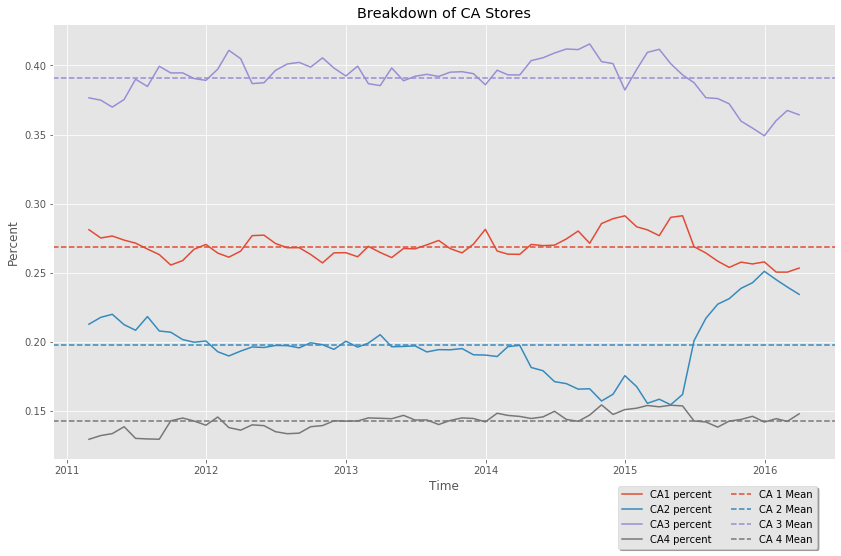

In [51]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_store_ca['ca1_percent'], label = 'CA1 percent')
ax.plot(sales_store_ca['ca2_percent'], label = 'CA2 percent')
ax.plot(sales_store_ca['ca3_percent'], label = 'CA3 percent')
ax.plot(sales_store_ca['ca4_percent'], label = 'CA4 percent')
ax.axhline(y=sales_store_ca.iloc[:, 5].mean(), xmin = 0, 
           linestyle = '--', color = 'C0', label = 'CA 1 Mean')
ax.axhline(y=sales_store_ca.iloc[:, 6].mean(), xmin = 0, 
           linestyle = '--', color = 'C1', label = 'CA 2 Mean')
ax.axhline(y=sales_store_ca.iloc[:, 7].mean(), xmin = 0, 
           linestyle = '--', color = 'C2', label = 'CA 3 Mean')
ax.axhline(y=sales_store_ca.iloc[:, 8].mean(), xmin = 0, 
           linestyle = '--', color = 'C3', label = 'CA 4 Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of CA Stores')
ax.legend(loc='upper center', bbox_to_anchor=(0.85, -0.05), shadow=True, ncol=2)
plt.savefig('../images/breakdown_of_CA_cat')
plt.show()

In [52]:
sales_store_ca

,CA_1,CA_2,CA_3,CA_4,TOTAL,ca1_percent,ca2_percent,ca3_percent,ca4_percent
date,,,,,,,,,
2011-02-28,89434,67686,119792,41189,318101,0.281150,0.212781,0.376585,0.129484
2011-03-31,93468,73964,127344,44902,339678,0.275166,0.217747,0.374896,0.132190
2011-04-30,91553,72803,122428,44220,331004,0.276592,0.219946,0.369869,0.133594
2011-05-31,87988,68305,120711,44562,321566,0.273623,0.212414,0.375385,0.138578
2011-06-30,90376,69380,129867,43325,332948,0.271442,0.208381,0.390052,0.130125
...,...,...,...,...,...,...,...,...,...
2015-11-30,123590,117037,170986,70434,482047,0.256386,0.242792,0.354708,0.146114
2015-12-31,123656,120396,167419,68080,479551,0.257858,0.251060,0.349116,0.141966
2016-01-31,131598,128709,189217,75868,525392,0.250476,0.244977,0.360144,0.144403


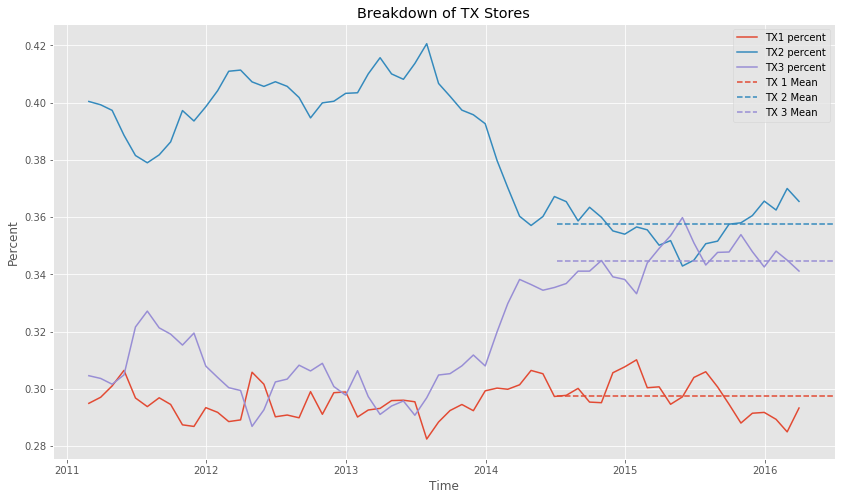

In [53]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_store_tx['tx1_percent'], label = 'TX1 percent')
ax.plot(sales_store_tx['tx2_percent'], label = 'TX2 percent')
ax.plot(sales_store_tx['tx3_percent'], label = 'TX3 percent')
ax.axhline(y=sales_store_tx.iloc[40:, 4].mean(), xmin = 40/62, 
           linestyle = '--', color = 'C0', label = 'TX 1 Mean')
ax.axhline(y=sales_store_tx.iloc[40:, 5].mean(), xmin = 40/62, 
           linestyle = '--', color = 'C1', label = 'TX 2 Mean')
ax.axhline(y=sales_store_tx.iloc[40:, 6].mean(), xmin = 40/62, 
           linestyle = '--', color = 'C2', label = 'TX 3 Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of TX Stores')
ax.legend()
plt.savefig('../images/breakdown_of_TX_cat')
plt.show()

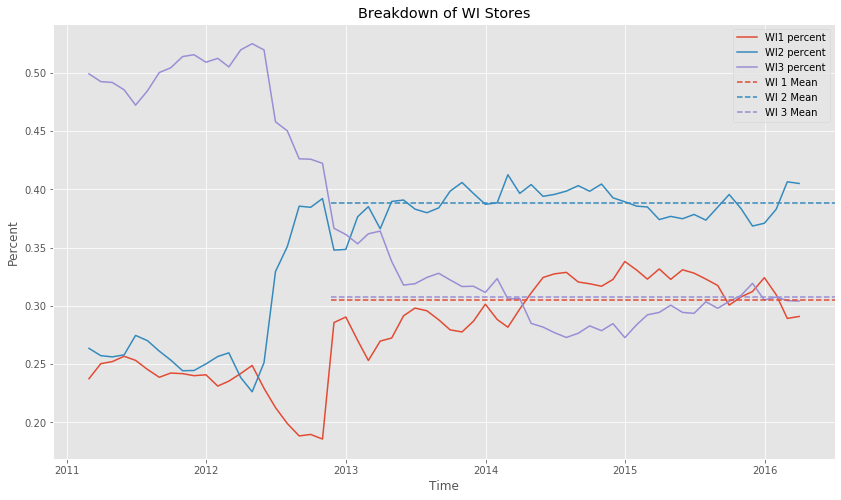

In [54]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.plot(sales_store_wi['wi1_percent'], label = 'WI1 percent')
ax.plot(sales_store_wi['wi2_percent'], label = 'WI2 percent')
ax.plot(sales_store_wi['wi3_percent'], label = 'WI3 percent')
ax.axhline(y=sales_store_wi.iloc[22:, 4].mean(), xmin = 22/62, 
           linestyle = '--', color = 'C0', label = 'WI 1 Mean')
ax.axhline(y=sales_store_wi.iloc[22:, 5].mean(), xmin = 22/62, 
           linestyle = '--', color = 'C1', label = 'WI 2 Mean')
ax.axhline(y=sales_store_wi.iloc[22:, 6].mean(), xmin = 22/62, 
           linestyle = '--', color = 'C2', label = 'WI 3 Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.set_title('Breakdown of WI Stores')
ax.legend()
plt.savefig('../images/breakdown_of_WI_cat')
plt.show()

In [ ]:
#Need to decide the percentage breakdown between stores (perhaps add a line on the graph to represent?)
#Need to pick one product and come up with a way to determine the monthly distribution
#Can try to do it in a way where you can pick any product and get the answer if you input the expected
    #Monthly sales for that store/department

In [333]:
#feb sales * Food Category * Food 3 * CA * CA3
feb_2016_forecast*sales_all.iloc[40:, 4].mean()*sales_dept_food.iloc[40:, 6].mean()*sales_state_all.iloc[40:, 4].mean()*sales_store_ca.iloc[:, 7].mean()

92050.9264831301

In [55]:
print(feb_2016_forecast, sales_all.iloc[40:, 4].mean(), sales_dept_food.iloc[40:, 6].mean(), sales_state_all.iloc[40:, 4].mean(), sales_store_ca.iloc[:, 7].mean())

1166909.051683145 0.6653962889488358 0.7001382623254212 0.4331419362421831 0.390927961601427


In [334]:
mar_2016_forecast*sales_all.iloc[40:, 4].mean()*sales_dept_food.iloc[40:, 6].mean()*sales_state_all.iloc[40:, 4].mean()*sales_store_ca.iloc[:, 7].mean()

99750.16013997377

In [557]:
def trickle_down_forecast(upper_forecast, actual, path_lst):
    forecast = upper_forecast * np.prod(path_lst)
    if actual == None:
        return forecast
    else:
        error = (forecast - actual)/actual
        return forecast, error

In [558]:
trickle_down_forecast(make_forecast(big_all, 'M', 2, 1, 2)[0], make_forecast(big_all, 'M', 2, 1, 2)[2], path_lst)

(92050.9264831301, -0.9241084364655663)

In [551]:
path_lst = [sales_all.iloc[40:, 4].mean(),
            sales_dept_food.iloc[40:, 6].mean(),
            sales_state_all.iloc[40:, 4].mean(),
            sales_store_ca.iloc[:, 7].mean()]
trickle_down_forecast(feb_2016_forecast, path_lst)

92050.9264831301

In [356]:
mask1 = sales_train['store_id'] == 'CA_3'
mask2 = sales_train['dept_id'] == 'FOODS_3'
sales_ca3_foods3 = sales_train[mask1 & mask2].copy()
sales_ca3_foods3 = sales_ca3_foods3.drop(columns = ['id', 'item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
sales_ca3_foods3.loc['TOTAL']= sales_ca3_foods3.sum()
sales_ca3_foods3 = sales_ca3_foods3.T
sales_ca3_foods3 = drop_christmas(sales_ca3_foods3)
sales_ca3_foods3 = make_date_time(sales_ca3_foods3)
#sales_ca3_foods3 = resample_series(sales_ca3_foods3, 'M')
sales_ca3_foods3 = sales_ca3_foods3['TOTAL'].to_frame()

sales_ca3_foods3

,TOTAL
date,
2011-01-29,2478
2011-01-30,2451
2011-01-31,1897
2011-02-01,2284
2011-02-02,1998
...,...
2016-04-20,2385
2016-04-21,2251
2016-04-22,2474


In [357]:
resample_series(sales_ca3_foods3, 'M')

,TOTAL
date,
2011-02-28,60302
2011-03-31,63020
2011-04-30,59716
2011-05-31,57601
2011-06-30,63093
...,...
2015-11-30,74413
2015-12-31,69982
2016-01-31,84782


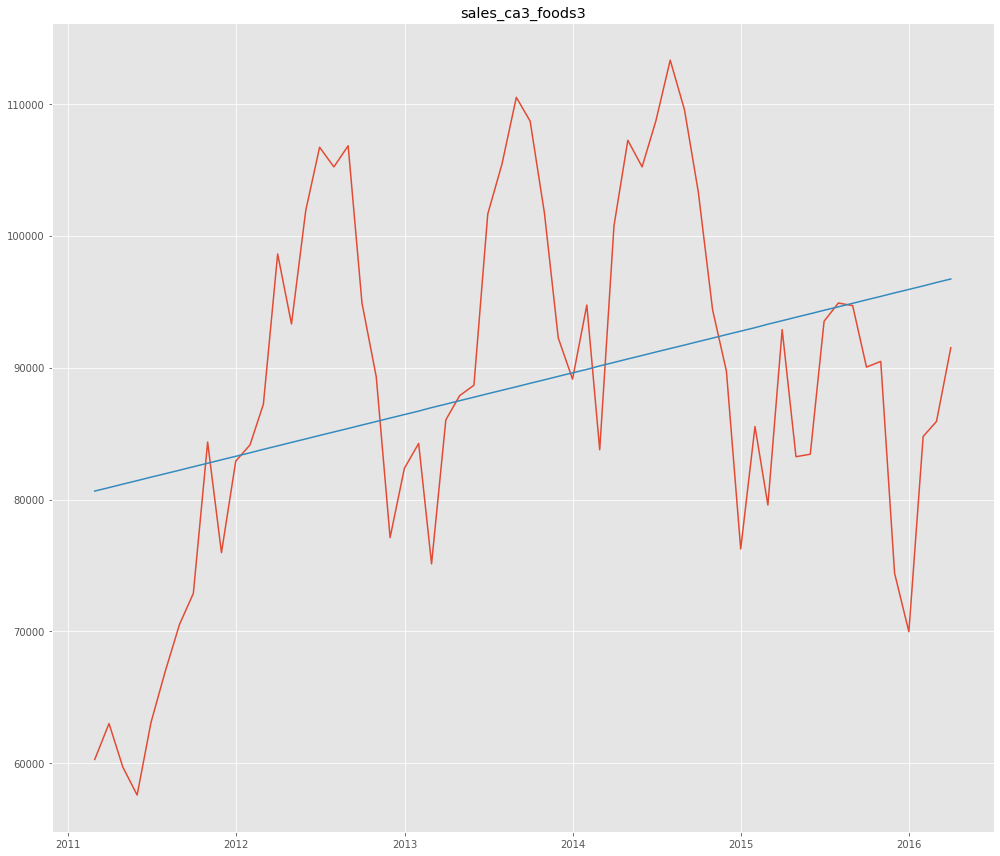

In [350]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'sales_ca3_foods3', resample_series(sales_ca3_foods3, 'M'))
plt.tight_layout()

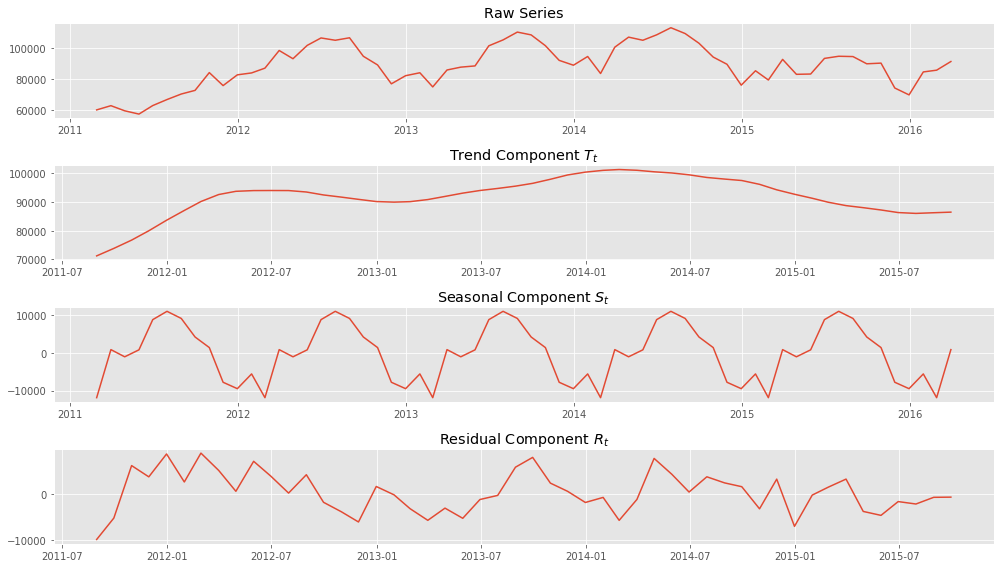

In [351]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(sales_ca3_foods3, 'M'))
plt.tight_layout()

In [354]:
sales_ca3_foods3_series = resample_series(sales_ca3_foods3, 'M')
sales_ca3_foods3_d = sales_ca3_foods3_series[:-2]

sales_ca3_foods3_X = make_design_matrix(np.arange(len(sales_ca3_foods3_d)) + 1)
sales_ca3_foods3_linear_trend_ols = sm.OLS(sales_ca3_foods3_d.values, sales_ca3_foods3_X).fit()

sales_ca3_foods3_slope_intercept = sales_ca3_foods3_linear_trend_ols.params
sales_ca3_foods3_slope = sales_ca3_foods3_slope_intercept[0]
sales_ca3_foods3_intercept = sales_ca3_foods3_slope_intercept[1]

sales_ca3_foods3_feb_2016_trend = sales_ca3_foods3_slope*(len(sales_ca3_foods3_d) + 1) + sales_ca3_foods3_intercept

sales_ca3_foods3_sd = sm.tsa.seasonal_decompose(sales_ca3_foods3_series)
sales_ca3_foods3_seasonal_pattern_all = sales_ca3_foods3_sd.seasonal[11:23]

sales_ca3_foods3_feb_2016_seasonal = sales_ca3_foods3_seasonal_pattern_all.loc[sales_ca3_foods3_seasonal_pattern_all.index.month == 2].iloc[0, 0]

sales_ca3_foods3_feb_2016_forecast = sales_ca3_foods3_feb_2016_trend + sales_ca3_foods3_feb_2016_seasonal
sales_ca3_foods3_feb_2016_forecast

85647.08911252356

In [358]:
sales_ca3_foods3_mar_2016_trend = sales_ca3_foods3_slope*(len(sales_ca3_foods3_d) + 2) + sales_ca3_foods3_intercept

sales_ca3_foods3_mar_2016_seasonal = sales_ca3_foods3_seasonal_pattern_all.loc[sales_ca3_foods3_seasonal_pattern_all.index.month == 3].iloc[0, 0]

sales_ca3_foods3_mar_2016_forecast = sales_ca3_foods3_mar_2016_trend + sales_ca3_foods3_mar_2016_seasonal
sales_ca3_foods3_mar_2016_forecast

98651.01800191413

In [533]:
sales_ca3_foods3_series

,TOTAL
date,
2011-02-28,60302
2011-03-31,63020
2011-04-30,59716
2011-05-31,57601
2011-06-30,63093
...,...
2015-11-30,74413
2015-12-31,69982
2016-01-31,84782


In [552]:
def make_forecast(series, interval, num_of_test_periods, forecast_period, forecast_month):
    '''
    Forecast Sales at Given Interval for a Given Series. Can be used to train, or to predict unseen data.
    
    Params:
    Series- Series that you want to forecast
    Interval- 'Q, M, W, d'
    num_of_test_periods- For example, if you enter '2' it will take your 'monthly' forecast
                         and will leave off the latest 2 periods so you can test against it for accuracy
    forecast_period- Can be up to the num_of_test_periods. If you leave off 2 months, you can forecast/predict
                     the first or the second month
    forecast_month-  If your forecast period is 1 and you are forecasting into february, you need to put a 2
                     so the seasonality for that month can be added in
    
    Returns:
    forecast- The projected units sold for that specific series
    error- will give you the error for what percent your forecast differs from actuals
    '''
    df = resample_series(series, interval)
    train_series = df[:-num_of_test_periods]
    X = make_design_matrix(np.arange(len(train_series)) + 1)
    linear_trend_ols = sm.OLS(train_series.values, X).fit()
    slope_intercept = linear_trend_ols.params
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    trend = slope*(len(train_series) + forecast_period) + intercept
    sd = sm.tsa.seasonal_decompose(df)
    seasonal_pattern = sd.seasonal[11:23]
    seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month].iloc[0, 0]
    forecast = trend + seasonal
    actual = df[-num_of_test_periods:].loc[df[-num_of_test_periods:].index.month == forecast_month].iloc[0, 0]
    error = (forecast-actual)/actual
    return forecast, error, actual

In [549]:
make_forecast(big_all, 'M', 2, 1, 2)[0]

1166909.051683145

In [359]:
#OLS on the sub sub category in this case gives a better forecast, perhaps I should compare for each category,
    #and then choose the model based on which one performs better? The OLS in this case performs better than the
    #trickle down model. It's much better in February but only slightly better in Mar.  Should put the above OLS 
        #in a function in order to replicate. Same thing for trickle down. #Maybe do OLS in a Class?

In [360]:
#Let's try to figure out the monthly pattern next.

In [407]:
#Test

mask1 = sales_train['store_id'] == 'CA_3'
mask2 = sales_train['dept_id'] == 'FOODS_3'
sales_ca3_foods3_test = sales_train[mask1 & mask2].copy()
sales_ca3_foods3_test = sales_ca3_foods3_test.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
#sales_ca3_foods3_test.loc['TOTAL']= sales_ca3_foods3_test.sum()
sales_ca3_foods3_test = sales_ca3_foods3_test.set_index('id')
#sales_ca3_foods3_test = sales_ca3_foods3_test.rename(index={sales_ca3_foods3_test.index[-1]: 'total'})
sales_ca3_foods3_test = sales_ca3_foods3_test.T
#sales_ca3_foods3_test = drop_christmas(sales_ca3_foods3_test)
sales_ca3_foods3_test = make_date_time(sales_ca3_foods3_test)
#sales_ca3_foods3_test.loc['TOTAL']= sales_ca3_foods3_test.sum()
#sales_ca3_foods3 = resample_series(sales_ca3_foods3, 'M')
#sales_ca3_foods3_test = sales_ca3_foods3_test['TOTAL'].to_frame()
sales_ca3_foods3_test['day'] = sales_ca3_foods3_test.index.day
sales_ca3_foods3_test['month'] = sales_ca3_foods3_test.index.month
sales_ca3_foods3_test['year'] = sales_ca3_foods3_test.index.year
sales_ca3_foods3_test['day_of_week'] = sales_ca3_foods3_test.index.dayofweek
sales_ca3_foods3_test = sales_ca3_foods3_test.iloc[:, list(range(1)) + [-3] + [-2] + [-1]]
sales_ca3_foods3_test = sales_ca3_foods3_test[sales_ca3_foods3_test['month'] == 2]
sales_ca3_foods3_test = sales_ca3_foods3_test[sales_ca3_foods3_test['year'] == 2011]
sales_ca3_foods3_test.loc['TOTAL']= sales_ca3_foods3_test.iloc[:, 0].sum()
sales_ca3_foods3_test[f'{list(sales_ca3_foods3_test)[0]}_percent'] = sales_ca3_foods3_test[list(sales_ca3_foods3_test)[0]] / sales_ca3_foods3_test.iloc[-1:, 0][0]


sales_ca3_foods3_test

,FOODS_3_001_CA_3_validation,month,year,day_of_week,FOODS_3_001_CA_3_validation_percent
date,,,,,
2011-02-01 00:00:00,0,2,2011,1,0.000000
2011-02-02 00:00:00,1,2,2011,2,0.024390
2011-02-03 00:00:00,2,2,2011,3,0.048780
2011-02-04 00:00:00,2,2,2011,4,0.048780
2011-02-05 00:00:00,2,2,2011,5,0.048780
2011-02-06 00:00:00,4,2,2011,6,0.097561
2011-02-07 00:00:00,0,2,2011,0,0.000000
2011-02-08 00:00:00,0,2,2011,1,0.000000
2011-02-09 00:00:00,0,2,2011,2,0.000000


In [414]:
#Test

mask1 = sales_train['store_id'] == 'CA_3'
mask2 = sales_train['dept_id'] == 'FOODS_3'
sales_ca3_foods3_test1 = sales_train[mask1 & mask2].copy()
sales_ca3_foods3_test1 = sales_ca3_foods3_test1.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
sales_ca3_foods3_test1 = sales_ca3_foods3_test1.set_index('id')
sales_ca3_foods3_test1 = sales_ca3_foods3_test1.T
sales_ca3_foods3_test1 = make_date_time(sales_ca3_foods3_test1)
sales_ca3_foods3_test1['day'] = sales_ca3_foods3_test1.index.day
sales_ca3_foods3_test1['month'] = sales_ca3_foods3_test1.index.month
sales_ca3_foods3_test1['year'] = sales_ca3_foods3_test1.index.year
sales_ca3_foods3_test1['day_of_week'] = sales_ca3_foods3_test1.index.dayofweek
sales_ca3_foods3_test1 = sales_ca3_foods3_test1.iloc[:, list(range(1)) + [-3] + [-2] + [-1]]
sales_ca3_foods3_test1 = sales_ca3_foods3_test1[sales_ca3_foods3_test1['month'] == 2]
sales_ca3_foods3_test1 = sales_ca3_foods3_test1[sales_ca3_foods3_test1['year'] == 2012]
sales_ca3_foods3_test1.loc['TOTAL']= sales_ca3_foods3_test1.iloc[:, 0].sum()
sales_ca3_foods3_test1[f'{list(sales_ca3_foods3_test1)[0]}_percent'] = sales_ca3_foods3_test1[list(sales_ca3_foods3_test1)[0]] / sales_ca3_foods3_test1.iloc[-1:, 0][0]

sales_ca3_foods3_test1

,FOODS_3_001_CA_3_validation,month,year,day_of_week,FOODS_3_001_CA_3_validation_percent
date,,,,,
2012-02-01 00:00:00,2,2,2012,2,0.068966
2012-02-02 00:00:00,0,2,2012,3,0.000000
2012-02-03 00:00:00,0,2,2012,4,0.000000
2012-02-04 00:00:00,1,2,2012,5,0.034483
2012-02-05 00:00:00,0,2,2012,6,0.000000
2012-02-06 00:00:00,0,2,2012,0,0.000000
2012-02-07 00:00:00,1,2,2012,1,0.034483
2012-02-08 00:00:00,0,2,2012,2,0.000000
2012-02-09 00:00:00,1,2,2012,3,0.034483


In [501]:
#Test

xxx = pd.DataFrame(list(sales_ca3_foods3_test1[list(sales_ca3_foods3_test1)].iloc[:, -1][:-1]))
lst = [temp_df1, temp_df2]
newDF = pd.DataFrame()
#newDF = pd.concat([temp_df1,temp_df2], ignore_index=True, axis=1)
#newDF = pd.concat([temp_df1], ignore_index=True, axis=1)
#newDF['average'] = newDF.mean(numeric_only=True, axis=1)
#newDF.loc['TOTAL']= newDF.sum()
#newDF = newDF.merge(temp_df1, how='outer')
newDF = pd.concat(lst, ignore_index=True, axis=1)
newDF
#list(sales_ca3_foods3_test1[list(sales_ca3_foods3_test1)].iloc[:, -1][:-1])

,0,1
0,0.000000,0.068966
1,0.024390,0.000000
2,0.048780,0.000000
3,0.048780,0.034483
4,0.048780,0.000000
5,0.097561,0.000000
6,0.000000,0.034483
7,0.000000,0.000000
8,0.000000,0.034483
9,0.195122,0.034483


In [531]:
#Function that does the above
def naive_monthly_distribution(store, department, product_id, lst_of_years, month_num):
    lst=[]
    newDF = pd.DataFrame()
    mask1 = sales_train['store_id'] == store
    mask2 = sales_train['dept_id'] == department
    df = sales_train[mask1 & mask2].copy()
    df = df.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    df = df.set_index('id')
    df = df.loc[[product_id]]
    df = df.T
    df = make_date_time(df)
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df = df[df['month'] == month_num]
    for year in lst_of_years:
        df1 = df.copy()
        df1 = df1[df1['year'] == year]
        df1.loc['TOTAL']= df1.iloc[:, 0].sum()
        df1[f'{list(df1)[0]}_percent'] = df[list(df1)[0]] / df1.iloc[-1:, 0][0]
        lst.append(pd.DataFrame(list(df1[list(df1)].iloc[:, -1][:-1])))
    newDF = pd.concat(lst, ignore_index=True, axis=1)
    newDF['average'] = newDF.mean(numeric_only=True, axis=1)
    newDF.loc['TOTAL']= newDF.sum()
    monthly_distribution = newDF.iloc[:-1, 5].to_numpy()
    return monthly_distribution

In [532]:
naive_monthly_distribution('CA_3', 'FOODS_3', 'FOODS_3_005_CA_3_validation', [2011, 2012, 2013, 2014, 2015], 2)

array([0.01089655, 0.04623336, 0.03304713, 0.02993703, 0.01834483,
       0.0151041 , 0.00689655, 0.02498598, 0.06779622, 0.04955686,
       0.02734866, 0.03612608, 0.06973442, 0.02688571, 0.13434011,
       0.03557436, 0.01788188, 0.04274208, 0.03251603, 0.02798916,
       0.01632632, 0.01178161, 0.01531165, 0.03143744, 0.04364251,
       0.07381957, 0.00955556, 0.03384341, 0.05172414])

In [523]:
#Test

mask11 = sales_train['store_id'] == 'CA_3'
mask22 = sales_train['dept_id'] == 'FOODS_3'
sales_ca3_foods3_test11 = sales_train[mask11 & mask22].copy()
sales_ca3_foods3_test11 = sales_ca3_foods3_test11.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
sales_ca3_foods3_test11 = sales_ca3_foods3_test11.set_index('id')
sales_ca3_foods3_test11 = sales_ca3_foods3_test11.loc[['FOODS_3_002_CA_3_validation']]
sales_ca3_foods3_test11 = sales_ca3_foods3_test11.T
sales_ca3_foods3_test11 = make_date_time(sales_ca3_foods3_test11)
sales_ca3_foods3_test11['day'] = sales_ca3_foods3_test11.index.day
sales_ca3_foods3_test11['month'] = sales_ca3_foods3_test11.index.month
sales_ca3_foods3_test11['year'] = sales_ca3_foods3_test11.index.year
sales_ca3_foods3_test11['day_of_week'] = sales_ca3_foods3_test11.index.dayofweek


sales_ca3_foods3_test11.head(20)

,FOODS_3_002_CA_3_validation,day,month,year,day_of_week
date,,,,,
2011-01-29,0,29,1,2011,5
2011-01-30,0,30,1,2011,6
2011-01-31,0,31,1,2011,0
2011-02-01,0,1,2,2011,1
2011-02-02,0,2,2,2011,2
2011-02-03,0,3,2,2011,3
2011-02-04,0,4,2,2011,4
2011-02-05,0,5,2,2011,5
2011-02-06,0,6,2,2011,6
